Анастасия Плавина

## Модель предсказания невыполнения клиентом долговых обязательств

**Цель проекта**: обучить модель предсказания невыполнения долговых обязательств клиентом по текущему кредиту на основе данных о клиенте банка.

**Метрика качества**: F1-score - метрика, показывающая гармоническое среднее между показателями precision и recall. В качестве baseline принимается значение 0.5

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestClassifier

### 1. Обзор датасета

**Целевая переменная**
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)



**Независимые переменные:**
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка кредитоспособности


### 2. Загрузка данных

In [2]:
train_path = 'course_project_train.csv'
test_path = 'course_project_test.csv'

In [3]:
df = pd.read_csv(train_path)
df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df.shape

(7500, 17)

In [5]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### 3. Обзор целевой переменной

Соотношение целевой переменной
0 (погашение) - 72%
1 (просрочка) - 28%


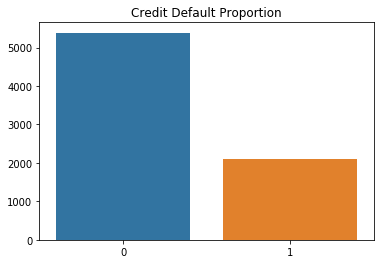

In [6]:
counts = df["Credit Default"].value_counts()

print('Соотношение целевой переменной')
print(f'0 (погашение) - {counts[0]/df.shape[0]*100:.0f}%')
print(f'1 (просрочка) - {counts[1]/df.shape[0]*100:.0f}%')


plt.figure(figsize=(6,4))    
plt.title('Credit Default Proportion')
sns.barplot(counts.index, counts.values)
plt.show()

### 4. Обзор признаков

In [7]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

#### 4.1 Категориальные признаки

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************



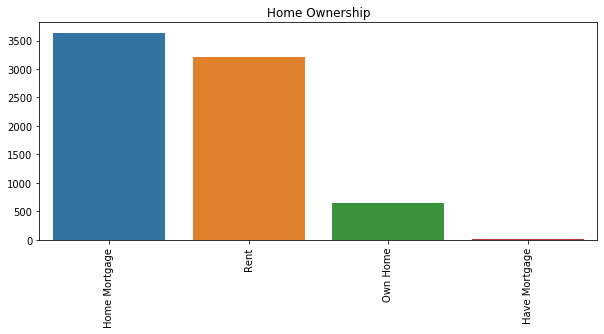

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************



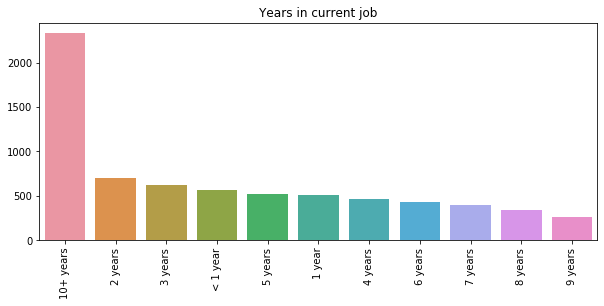

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************



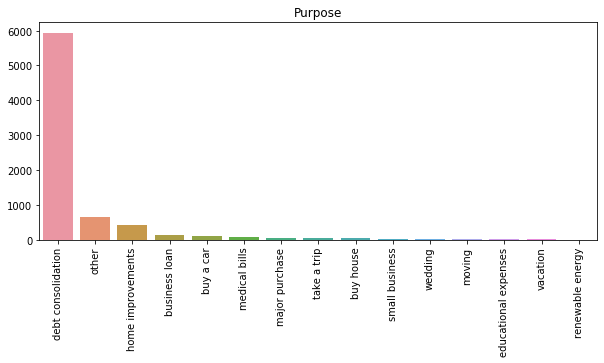

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
****************************************************************************************************



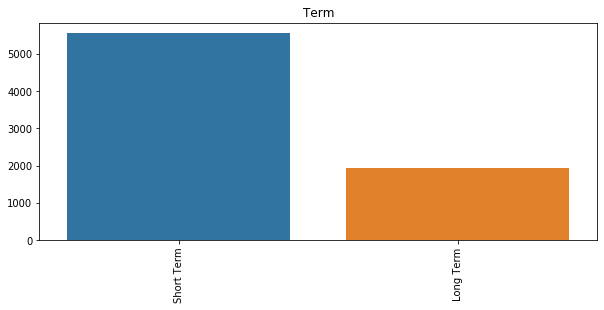

In [8]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
    counts = df[cat_colname].value_counts()
    plt.figure(figsize=(10,4))    
    plt.title(cat_colname)
    plt.xticks(rotation=90)
    sns.barplot(counts.index, counts.values)
    plt.show()

#### 4.2. Обзор количественных признаков

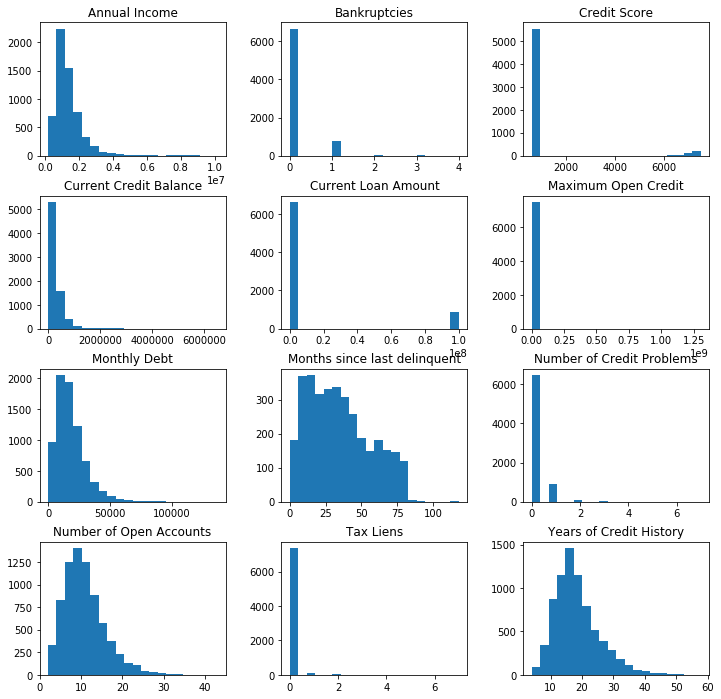

In [9]:
df_num_features =  df.select_dtypes(exclude=['object', 'int'])

df_num_features.hist(figsize=(12,12), bins=20, grid=False)
plt.show()

In [10]:
num_discreet = ['Bankruptcies', 'Number of Credit Problems','Tax Liens']

for colname in df[num_discreet]:
    print(str(colname) + '\n\n' + str(df[colname].value_counts()) + '\n' + '*' * 100 + '\n')

Bankruptcies

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************



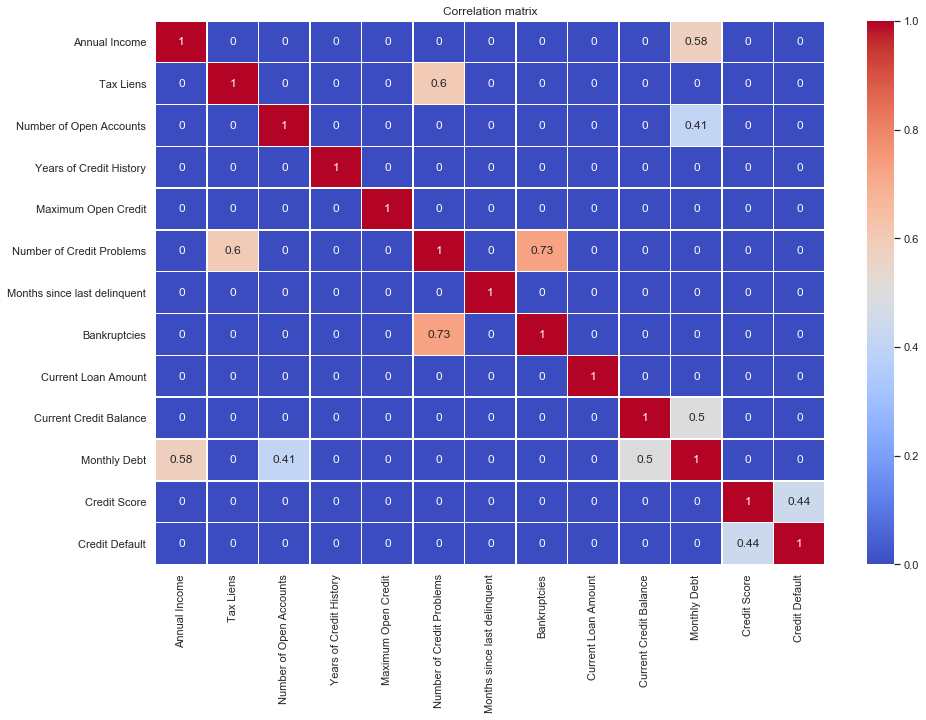

In [11]:
plt.figure(figsize = (15,10))
sns.set(font_scale=1)


corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.4] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

**Выводы по корреляционной матрице:**

1. Наблюдается наибольшая корреляция таргета с показателем Credit Score.
2. Количество ситуаций, когда клиент объявляет о банкротстве, коррелирует с количеством проблем по кредиту.
3. Количество проблем по кредитам, в свою очередь, коррелирует с уровнем налоговых обременений.
4. Месячный долг демонстрирует корреляцию с годовым доходом, количеством открытых счетов и текущим остатком по кредиту.

### 5. Обработка пропусков и выбросов

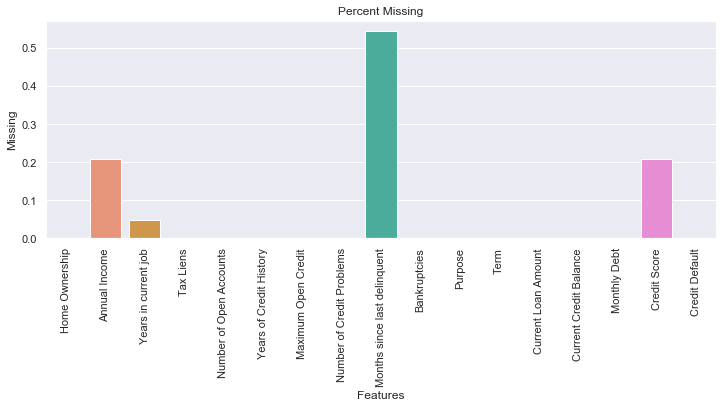

In [12]:
nan_df = (df.isna().sum() / df.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(12,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [13]:
df['Annual Income'].fillna(df['Annual Income'].mode()[0], inplace=True)
df['Years in current job'].fillna(df['Years in current job'].mode()[0], inplace=True)
df['Annual Income'].fillna(df['Annual Income'].mode()[0], inplace=True)
df['Credit Score'].fillna(df['Credit Score'].mode()[0], inplace=True)

In [14]:
# для клиентов, у которых не было проблем по кредиту, заполняем на -1 пропуски в графе кол-во месяцев с просрочки
# последнего платежа, заполняем пропуски в Bankruptcies нулями, если не было проблем по кредиту

df.loc[(df['Number of Credit Problems'] == 0) & (df['Months since last delinquent'].isna()), 'Months since last delinquent'] = -1
df.loc[(df['Number of Credit Problems'] == 0) & (df['Bankruptcies'].isna()), 'Bankruptcies'] = 0

In [15]:
# остальные пропуски заполняем модой


df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0], inplace=True)
df['Months since last delinquent'].fillna(df['Months since last delinquent'].mode()[0], inplace=True)

In [16]:
# обрабатываем выбросы в Credit Score

df.loc[df['Credit Score'] > 850, 'Credit Score'] = df.loc[df['Credit Score'] > 850, 'Credit Score']/10

### 6. Генерация новых признаков

In [17]:
X = df.drop('Credit Default', axis=1)
y = df[['Credit Default']]

In [18]:
# создание ID
X['ID'] = X.index.tolist()

In [19]:
#создание колонки с преобразованными в числа сроками работы на текущем месте работы клиента, пропуски заполняем модой
X['Years_in_cur_job_int'] = 10
 
X.loc[X['Years in current job'] == '< 1 year', 'Years_in_cur_job_int'] = 0  
X.loc[X['Years in current job'] == '1 year', 'Years_in_cur_job_int'] = 1
X.loc[X['Years in current job'] == '2 years', 'Years_in_cur_job_int'] = 2  
X.loc[X['Years in current job'] == '3 years', 'Years_in_cur_job_int'] = 3
X.loc[X['Years in current job'] == '4 years', 'Years_in_cur_job_int'] = 4 
X.loc[X['Years in current job'] == '5 years', 'Years_in_cur_job_int'] = 5
X.loc[X['Years in current job'] == '6 years', 'Years_in_cur_job_int'] = 6
X.loc[X['Years in current job'] == '7 years', 'Years_in_cur_job_int'] = 7 
X.loc[X['Years in current job'] == '8 years', 'Years_in_cur_job_int'] = 8
X.loc[X['Years in current job'] == '9 years', 'Years_in_cur_job_int'] = 9 
X.loc[X['Years in current job'] == '10+ years', 'Years_in_cur_job_int'] = 10   

In [20]:
# преобразование бинарных признаков
X['Term_bool'] = X['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [21]:
# преобразовываем категориальные признаки в dummy признаки
for cat_colname in X.select_dtypes(include='object').columns:
    X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)

In [22]:
X.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'ID', 'Years_in_cur_job_int', 'Term_bool',
       'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Purpose_business loan',
       'Purpose_buy a car', 'Purpose_buy

In [23]:
remain_features = ['Annual Income', 'Tax Liens',
                   'Number of Open Accounts', 'Years of Credit History',
                   'Maximum Open Credit', 'Number of Credit Problems',
                   'Months since last delinquent', 'Bankruptcies',
                   'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                   'Credit Score', 'ID', 'Years_in_cur_job_int', 'Term_bool',
                   'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
                   'Home Ownership_Own Home', 'Home Ownership_Rent',
                   'Years in current job_1 year', 'Years in current job_10+ years',
                   'Years in current job_2 years', 'Years in current job_3 years',
                   'Years in current job_4 years', 'Years in current job_5 years',
                   'Years in current job_6 years', 'Years in current job_7 years',
                   'Years in current job_8 years', 'Years in current job_9 years',
                   'Years in current job_< 1 year', 'Purpose_business loan',
                   'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
                   'Purpose_educational expenses', 'Purpose_home improvements',
                   'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
                   'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
                   'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
                   'Term_Long Term', 'Term_Short Term']

X = X[remain_features]

### 8. Обучение модели и кросс-валидация

In [24]:
model = AdaBoostClassifier(n_estimators=100, random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='f1', 
                           cv=KFold(n_splits=7, shuffle=True, random_state=42))
mean = cv_score.mean()
std = cv_score.std()

print('f1: {:.3f} +- {:.3f}'.format(mean, std))
print(cv_score)

model.fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validati

f1: 0.313 +- 0.026
[0.2763466  0.33407572 0.32110092 0.27160494 0.31707317 0.34562212
 0.32289157]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=42)

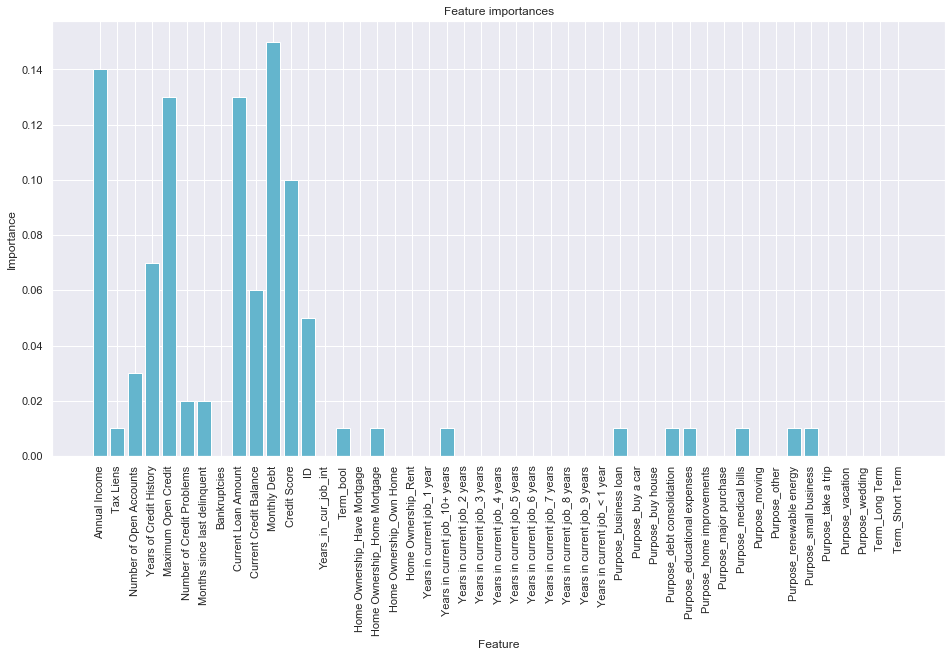

In [25]:
importances = model.feature_importances_
plt.figure(figsize = [16, 8])
plt.bar(X.columns, importances, color='c')
plt.title('Feature importances')
plt.xlabel('Feature')
plt.xticks(rotation = 90)
plt.ylabel('Importance')
plt.show()

### 10. Предсказание